In [31]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import torch
import numpy as np
import os
import plotly.express as px
import time
from matplotlib import pyplot as plt

# * Help ME GOD math functions
def gaussian_probability(x, mu, sigma):
    # Gaussian distribution formula
    prob = (1/ (np.sqrt(2 * np.pi * sigma**2))) * np.exp( - ((x - mu)**2) / (2 * sigma**2))
    return prob

def HighlightFunction(x,foco):
    # create an array with the same shape as x, zero everwhere except where x is equal to foco
    foco_array = np.zeros(x.shape)
    foco_array[x==foco] = 1
    final = x*foco_array
    return final

# * Image Loading and Saving
def save_image(image:np.ndarray, path:str,file_name:str,scale=False)->None:
    # save image to path
    if(not os.path.exists(path)):
        os.makedirs(path)
    
    # convert to uint8
    #print(image)
    if(scale):
        image = (image*255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    image = Image.fromarray(image)
    path = os.path.join(path,file_name)
    image.save(path)

def load_image(path:str)->np.ndarray:
    # load image from path
    if(not os.path.exists(path)):
        print("Path does not exist")
        return np.random.rand(128,128,3)
    image = Image.open(path)
    image = image.resize((128,128)) # resize image to 128x128
    # convert image to np array
    image = np.array(image)
    # remove alpha channel
    if(image.shape[2]==4):
        image = image[:,:,:3]
    return image


# * Model Loading for processing
def SegFormer(image:np.ndarray)->np.ndarray:
    # load model
    processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
    model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
    # process image
    inputs = processor(image,return_tensors="pt",do_reduce_labels=False)
    outputs = model(**inputs) ## the ** is used to unpack the dictionary
    logits = outputs.logits # shape (batch_size, num_classes, height/4, width/4)

    # convert type to numpy array
    logits = logits.detach().numpy()
    logits = logits[0] # remove batch dimension
    # normalize values between 0 and 1
    logits = np.argmax(logits.squeeze(), axis=0)
    logits = logits - logits.min()
    logits = logits / logits.max()
    return logits # return logits in 0,1 range.

def MaskProcessing(logits:np.ndarray,focus=0.1)->np.ndarray:
    # Take in the logits in range 0,1
    # Identify the color rigions
    regions = []
    # turn logits from float to int
    logits = logits*10
    logits = logits.astype(np.uint8)

    # convert to torch and use sigmoid to make it an attention mask
    logits_torch = torch.from_numpy(logits)
    #logits_torch = torch.sigmoid(logits_torch**2) # sigmoid to make similar integers to have the same value
    logits = logits_torch.detach().numpy()
    # find unique values
    unique = np.unique(logits)
    # iterate through unique values, pass each through the gaussian probability function
    masks = []
    for value in unique:
        # find the probability of the value
        prob_logits = gaussian_probability(logits,value,sigma=focus)
        # if the probability is greater than 0.5, append it to the regions
        # normalize the probability
        prob_logits = prob_logits - prob_logits.min()
        prob_logits = prob_logits / prob_logits.max()
        masks.append(prob_logits) # probabilistic mask that highlights given value
    return masks

def ApplyMask(image:np.ndarray,mask:np.ndarray)->np.ndarray:
    # reshape the mask to (128,128,3)
    mask = np.stack((mask,mask,mask),axis=2)
    #print(mask.shape)
    #print(image.shape)
    return image*mask

def Cropper(mask:np.ndarray,original_recipi_chicken:np.ndarray)->tuple:
    # take in the mask, find the first index on each axis that reaches greater than 0.9
    # find the last index on each axis that reaches greater than 0.9
    valve = 0.8
    print(mask.shape)
    # temperarily remove the alpha channel
    temp = mask[:,:,1]
    
    # go through every row and column
    min_row, max_row, min_col, max_col = len(mask), 0, len(mask[0]), 0

    # standarize the mask
    temp = temp - temp.min()
    temp = temp / temp.max()
    # check if the row is greater than the valve
    for row in range(len(temp)):
        if(np.any(temp[row]>valve)):
            if(row<min_row):
                min_row = row
            if(row>max_row):
                max_row = row
    # check if the column is greater than the valve
    for col in range(len(temp[0])):
        if(np.any(temp[:,col]>valve)):
            if(col<min_col):
                min_col = col
            if(col>max_col):
                max_col = col
    # add padding if possible
    if(min_row>20):
        min_row -= 10
    if(min_col>20):
        min_col -= 10
    if(max_row<len(temp)-20):
        max_row += 10
    if(max_col<len(temp[0])-20):
        max_col += 10
        
    print(temp)

    cropped_img = mask[min_row:max_row+1, min_col:max_col+1, :]
    cropped_original = original_recipi_chicken[min_row:max_row+1, min_col:max_col+1, :]
    return cropped_img,cropped_original

def plot_image(images:list)->None: # list of np.ndarray
    # plot all images in the list togather
    # create a subplot
    size = len(images)*5
    fig = plt.figure(figsize=(size,size))
    for i in range(len(images)):
        fig.add_subplot(1,len(images),i+1)
        plt.imshow(images[i])
    plt.show()


def test():
    # parameters
    sd = 5
    # load image test1.pg
    image = load_image("images/bags.jpg")
    print(image.shape)
    # process image
    output = SegFormer(image)
    print(output.shape)
    # save image
    # convert output to image
    outputs = MaskProcessing(output,focus=sd)
    print(f"Number of Outputs: {len(outputs)}")
    # go through each output and save them
    # name the main folder with time
    path = "records/"+str(int(time.time()))
    # save the original image as original.png
    save_image(image,path,"original.png")
    i = 1
    for output in outputs:
        # save the ouputs as output1.png, output2.png, etc
        save_image(output,path,"output"+str(i)+".png",scale=True)
        # apply mask
        masked_image = ApplyMask(image,output)
        # save masked image as masked1.png, masked2.png, etc
        save_image(masked_image,path,"masked"+str(i)+".png")
        # crop the image
        cropped_masked,cropped_image = Cropper(masked_image,image)
        save_image(cropped_image,path,"cropped"+str(i)+".png")
        save_image(cropped_masked,path,"cropped_mapped"+str(i)+".png")
        i+=1
    

    


# Light weight Object Detetion

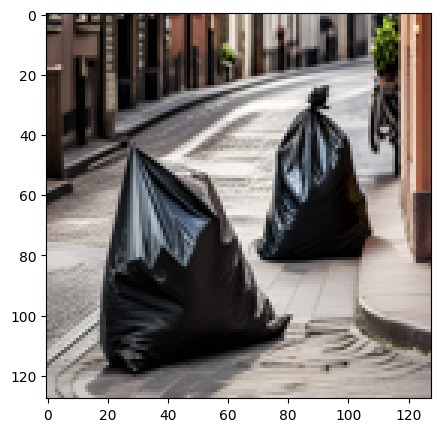

In [32]:
image = load_image("images/bags.jpg")
plot_image([image])


/Users/xyle/Code/AGI/BasicExperiments/.VENVexperiments/lib/python3.8/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning:

The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.



Time taken: 1.2872629999999994


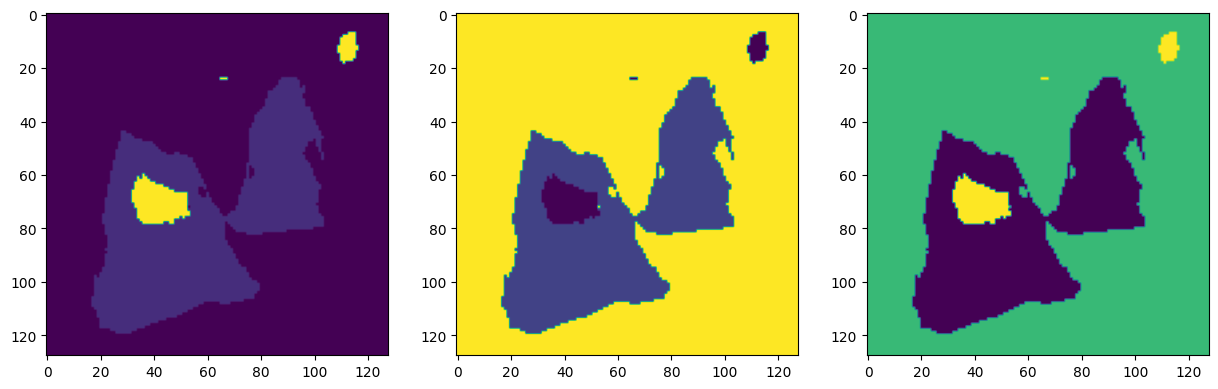

In [33]:
from time import process_time
start = process_time()
output = SegFormer(image)
end = process_time()
print(f"Time taken: {end-start}")
outputs = MaskProcessing(output,focus=5)
plot_image(outputs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


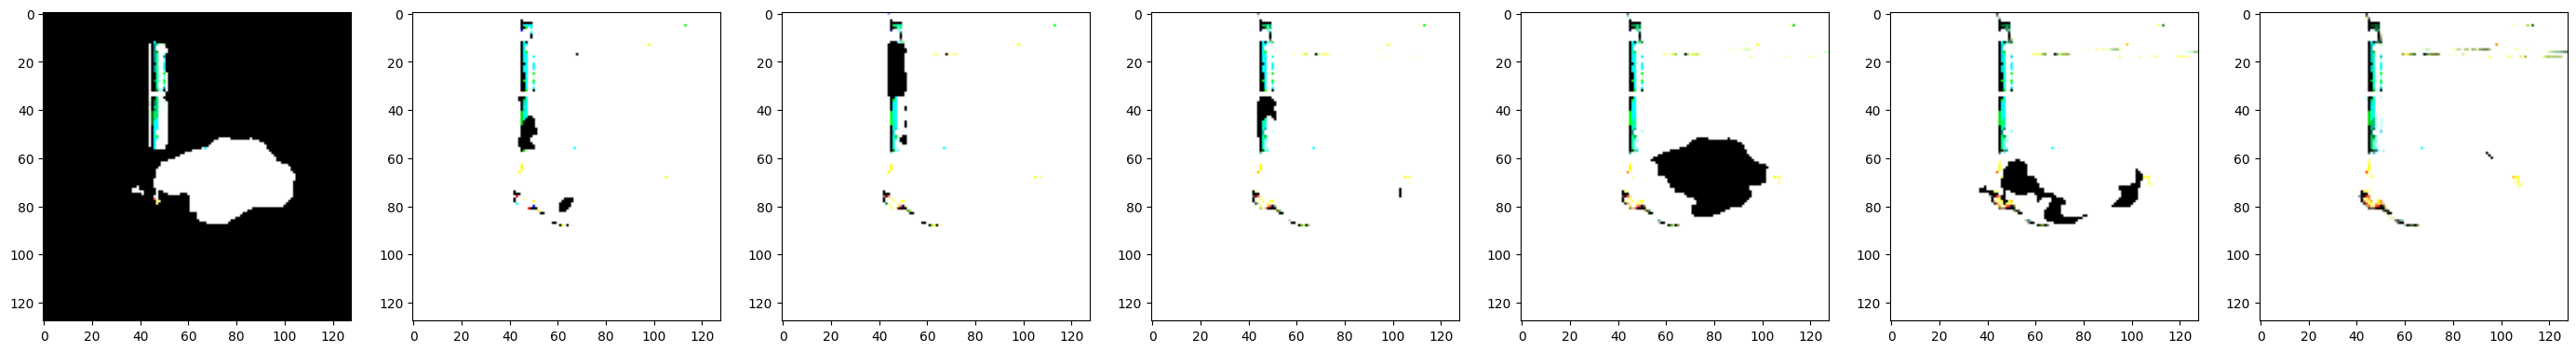

In [27]:
masked_images = [ApplyMask(image,output) for output in outputs]
plot_image(masked_images)